# Visualisation Examples

This notebook shows some of the visualisation utility of our toolkit.

The core packages for visualisation are:
### `rasterization`
contains classes for getting visual data as multi-channel tensors and turning them into interpretable RGB images.
Every class has at least a `rasterize` method to get the tensor and a `to_rgb` method to convert it into an image.
A few examples are:
- `BoxRasterizer`: this object renders agents (e.g. vehicles or pedestrians) as oriented 2D boxes
- `SatelliteRasterizer`: this object renders an oriented crop from a satellite map

### `visualization`
contains utilities to draw additional information (e.g. trajectories) onto RGB images. These utilities are commonly used after a `to_rgb` call to add other information to the final visualisation. 
One example is:
- `draw_trajectory`: this function draws 2D trajectories from coordinates and yaws offset on an image


In [6]:
#@title Download L5 Sample Dataset and install L5Kit
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/setup_notebook_colab.sh -q
    !sh ./setup_notebook_colab.sh
    os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()
else:
    os.environ["L5KIT_DATA_FOLDER"] = "/mnt/datasets/"
    print("Not running in Google Colab.")

Not running in Google Colab.


In [2]:
import matplotlib.pyplot as plt

import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import os

from l5kit.visualization.visualizer.zarr_utils import zarr_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

### First, let's configure where our data lives!
The data is expected to live in a folder that can be configured using the `L5KIT_DATA_FOLDER` env variable. You data folder is expected to contain subfolders for the aerial and semantic maps as well as the scenes (`.zarr` files). 
In this example, the env variable is set to the local data folder. You should make sure the path points to the correct location for you.

We built our code to work with a human-readable `yaml` config. This config file holds much useful information, however, we will only focus on a few functionalities concerning loading and visualization here.

In [7]:
# Dataset is assumed to be on the folder specified
# in the L5KIT_DATA_FOLDER environment variable

# get config
cfg = load_config_data("./visualisation_config.yaml")

### We can look into our current configuration for interesting fields

\- when loaded in python, the `yaml`file is converted into a python `dict`. 

`raster_params` contains all the information related to the transformation of the 3D world onto an image plane:
  - `raster_size`: the image plane size
  - `pixel_size`: how many meters correspond to a pixel
  - `ego_center`: our raster is centered around an agent, we can move the agent in the image plane with this param
  - `map_type`: the rasterizer to be employed. We currently support a satellite-based and a semantic-based one. We will look at the differences further down in this script

In [4]:
print(f'current raster_param:\n')
for k,v in cfg["raster_params"].items():
    print(f"{k}:{v}")

current raster_param:

raster_size:[84, 84]
pixel_size:[0.5, 0.5]
ego_center:[0.25, 0.5]
map_type:py_semantic
satellite_map_key:aerial_map/aerial_map.png
semantic_map_key:semantic_map/semantic_map.pb
dataset_meta_key:meta.json
filter_agents_threshold:0.5
disable_traffic_light_faces:False
set_origin_to_bottom:True


## Load the data

The same config file is also used to load the data. Every split in the data has its own section, and multiple datasets can be used (as a whole or sliced). In this short example we will only use the first dataset from the `sample` set. You can change this by configuring the 'train_data_loader' variable in the config.

You may also have noticed that we're building a `LocalDataManager` object. This will resolve relative paths from the config using the `L5KIT_DATA_FOLDER` env variable we have just set.

In [8]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["train_data_loader"]["key"])
train_zarr_dataset = ChunkedDataset(dataset_path)
train_zarr_dataset.open()
print(train_zarr_dataset)
###################################
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
val_zarr_dataset = ChunkedDataset(dataset_path)
val_zarr_dataset.open()
print(val_zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Nu

## Working with the raw data

`.zarr` files support most of the traditional numpy array operations. In the following cell we iterate over the frames to get a scatter plot of the AV locations:

In [9]:
frames = train_zarr_dataset.frames
coords = np.zeros((len(frames), 2))
for idx_coord, idx_data in enumerate(tqdm(range(len(frames)), desc="getting centroid to plot trajectory")):
    frame = train_zarr_dataset.frames[idx_data]
    coords[idx_coord] = frame["ego_translation"][:2]


plt.scatter(coords[:, 0], coords[:, 1], marker='.')
axes = plt.gca()
axes.set_xlim([-2500, 1600])
axes.set_ylim([-2500, 1600])

getting centroid to plot trajectory:   0%|          | 9533/4039527 [00:05<35:14, 1905.81it/s]


KeyboardInterrupt: 

Another easy thing to try is to get an idea of the agents types distribution. 

We can get all the agents `label_probabilities` and get the argmax for each raw. because `.zarr` files map to numpy array we can use all the traditional numpy operations and functions.

In [11]:
agents = train_zarr_dataset.agents
probabilities = agents["label_probabilities"]
labels_indexes = np.argmax(probabilities, axis=1)
counts = []
for idx_label, label in enumerate(PERCEPTION_LABELS):
    counts.append(np.sum(labels_indexes == idx_label))
    
table = PrettyTable(field_names=["label", "counts"])
for count, label in zip(counts, PERCEPTION_LABELS):
    table.add_row([label, count])
print(table)

MemoryError: Unable to allocate 20.3 GiB for an array with shape (320124624, 17) and data type float32

## Working with data abstraction

Even though it's absolutely fine to work with the raw data, we also provide classes that abstract data access to offer an easier way to generate inputs and targets.

### Core Objects
Along with the `rasterizer`, our toolkit contains other classes you may want to use while you build your solution. The `dataset` package, for example, already implements `PyTorch` ready datasets, so you can hit the ground running and start coding immediately.

### Dataset package
We will use two classes from the `dataset` package for this example. Both of them can be iterated and return multi-channel images from the rasterizer along with future trajectories offsets and other information.
- `EgoDataset`: this dataset iterates over the AV annotations
- `AgentDataset`: this dataset iterates over other agents annotations

Both support multi-threading (through PyTorch DataLoader) OOB.

In [12]:
rast = build_rasterizer(cfg, dm)

## What if I want to visualise the Autonomous Vehicle (AV)?

Let's get a sample from the dataset and use our `rasterizer` to get an RGB image we can plot. 

If we want to plot the ground truth trajectory, we can convert the dataset's `target_position` (displacements in meters in agent coordinates) into pixel coordinates in the image space, and call our utility function `draw_trajectory` (note that you can use this function for the predicted trajectories, as well).

(84, 84, 5)


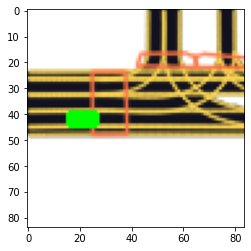

In [20]:
dataset = EgoDataset(cfg, train_zarr_dataset, rast)
data = dataset[102]

im = data["image"].transpose(1, 2, 0)
# im = data["image"].reshape(224,224,7)
print(im.shape)
im = dataset.rasterizer.to_rgb(im)
# target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
# draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im)
plt.show()

(84, 84, 3)


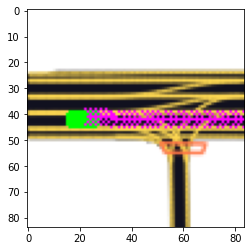

In [14]:
dataset = EgoDataset(cfg, train_zarr_dataset, rast)
data = dataset[2]

# import torch
# im = torch.tensor(data["image"]).permute(1, 2, 0)
im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
print(im.shape)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im)
plt.show()

## What if I want to change the rasterizer?

We can do so easily by building a new rasterizer and new dataset for it. In this example, we change the value to `py_satellite` which renders boxes on an aerial image.

In [34]:
cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
data = dataset[0]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im)
plt.show()

FileNotFoundError: aerial_map/aerial_map.png is not present in local data folder /media/pronton/linux_files/a100code/l5kit/l5kit_dataset

## What if I want to visualise an agent?

Glad you asked! We can just replace the `EgoDataset` with an `AgentDataset`. Now we're iterating over agents and not the AV anymore, and the first one happens to be the pace car (you will see this one around a lot in the dataset).

In [ ]:
dataset = AgentDataset(cfg, train_zarr_dataset, rast)
data = dataset[2]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im)
plt.show()

## System Origin and Orientation

~At this point you may have noticed that we vertically flip the image before plotting it.~

Vertical flipping is not required anymore as it's already performed inside the rasteriser.


Further, all our rotations are counter-clockwise for positive value of the angle.

## How does an entire scene look like?

It's easy to visualise an individual scene using our toolkit. Both `EgoDataset` and `AgentDataset` provide 2 methods for getting interesting indices:
- `get_frame_indices` returns the indices for a given frame. For the `EgoDataset` this matches a single observation, while more than one index could be available for the `AgentDataset`, as that given frame may contain more than one valid agent
- `get_scene_indices` returns indices for a given scene. For both datasets, these might return more than one index

In this example, we visualise a scene from the ego's point of view:

In [31]:
from IPython.display import display, clear_output
import PIL
from l5kit.visualization.video import write_video
 
cfg["raster_params"]["map_type"] = "py_semantic"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, train_zarr_dataset, rast)
scene_idx = 101
indexes = dataset.get_scene_indices(scene_idx)
# images = []

im1 =[]
cur = 107
for scene_idx in range(cur-5, cur):
    indexes = dataset.get_scene_indices(scene_idx)
    for idx in indexes:
        
        data = dataset[idx]
        im = data["image"].transpose(1, 2, 0) # C, W, H -> W,H,C
        im = dataset.rasterizer.to_rgb(im)
        target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
        center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
        draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])
        # clear_output(wait=True)
        im1.append(im)
        # display(PIL.Image.fromarray(im))
write_video(f'/home/pronton/rl/rlhf-car/src/pref/preferences/visualization/cur_scene{cur-5}_{cur}.mp4', im1, resolution=(224,224))

OpenCV: FFMPEG: tag 0x34504d46/'FMP4' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


# Introducing a new visualizer
starting from l5kit `v1.3.0` you can now use an interactive visualiser (based on Bokeh) to inspect the scene.

The visualization can be built starting from individual scenes and allows for a closer inspection over ego, agents and trajectories.

`PRO TIP`: try to hover over one agent to show information about it

In [ ]:
output_notebook()
mapAPI = MapAPI.from_cfg(dm, cfg)
for scene_idx in range(10):
    out = zarr_to_visualizer_scene(zarr_dataset.get_scene_dataset(scene_idx), mapAPI)
    out_vis = visualize(scene_idx, out)
    show(out_vis)